In [86]:
import os
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import nltk

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
data = "/content/drive/MyDrive/Wiki-Vote.txt"

In [89]:
content = []
with open(data) as f:
    content = f.readlines()

info = content[:3]
content = content[3::]
for i, line in enumerate(content):
    content[i] = nltk.RegexpTokenizer(r"\w+").tokenize(line)
info[-1] = nltk.RegexpTokenizer(r"\w+").tokenize(info[-1])

df = pd.DataFrame(content[1::], columns = content[0])
df["FromNodeId"] = df["FromNodeId"].map(int)
df["ToNodeId"] = df["ToNodeId"].map(int)
    

In [90]:
df

,FromNodeId,ToNodeId
0,30,1412
1,30,3352
2,30,5254
3,30,5543
4,30,7478
...,...,...
103684,8272,4940
103685,8273,4940
103686,8150,8275
103687,8150,8276


In [91]:
G = nx.from_pandas_edgelist(df,source = "FromNodeId", target = "ToNodeId")
G = G.to_directed()

In [92]:
def PageRank(G):
    node_val = {}
    pg_rank = {}
    errors = []
    total_nodes = G.number_of_nodes()

    alpha = 0.85
    iterations = 100
    
    for node in G.nodes():
        pg_rank[node] = 1/total_nodes
        node_val[node] = 0
        

    for _ in range(iterations):            
        for node in G.nodes():
            output_edges = G.out_edges(node)
            n_edges = len(output_edges)
            for edge in output_edges:
                node_val[edge[1]] += pg_rank[edge[0]]/n_edges

        for node in G.nodes():
            node_val[node] = (1-alpha)/total_nodes + alpha*node_val[node]
        
        error = mse(list(pg_rank.values()),list(node_val.values()))
        errors.append(error)
        
        for node in G.nodes():
            pg_rank[node] = node_val[node]
            node_val[node] = 0
        
        if error < 1e-15:
            break
        
    return errors, pg_rank

In [93]:
error, rank = PageRank(G)

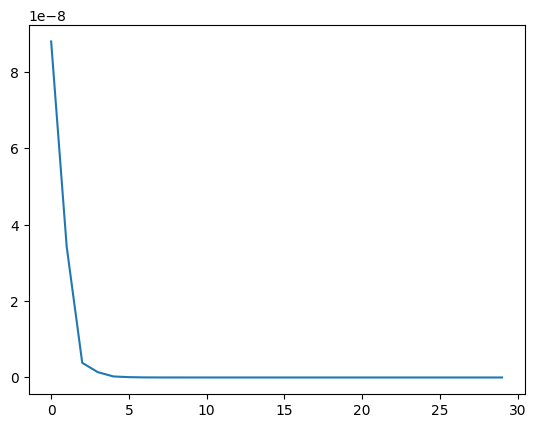

In [94]:
plt.plot(error)

In [95]:
def authority_hubs(G, max_iters = 100):
    hub = {}
    authority = {}
    error1 = []
    error2 = []
    
    for node in G.nodes():
        hub[node] = 1
        authority[node] = 1
    
    temp_auth = authority.copy()
    temp_hub = hub.copy()
    
    
    for _ in range(max_iters):
        ### updating authority scores
        temp=0    
        for node in G.nodes():
            edges = G.in_edges(node)
            authority[node] = 0
          
            for edge in edges:  
              authority[node] += hub[edge[0]]
                    
            temp += authority[node]**2
        temp = np.sqrt(temp)
        for node in G.nodes():
            authority[node] /= temp 

        ### updating hub scores
        temp=0
        for node in G.nodes():
            edges = G.out_edges(node)
            hub[node] = 0
          
            for edge in edges:  
              hub[node] += authority[edge[1]]
                    
            temp += hub[node]**2
        temp = np.sqrt(temp)
        for node in G.nodes():
            hub[node] /= temp 


        
        error1.append(mse(list(authority.values()),list(temp_auth.values())))
        error2.append(mse(list(hub.values()),list(temp_hub.values())))

        temp_auth = authority.copy()
        temp_hub = hub.copy()
        
        if error1[-1] < 1e-20 and error2[-1] < 1e-20:
            break
            
    return authority, hub, error1[1::], error2[1::]

In [96]:
authority, hub, error1, error2 = authority_hubs(G)

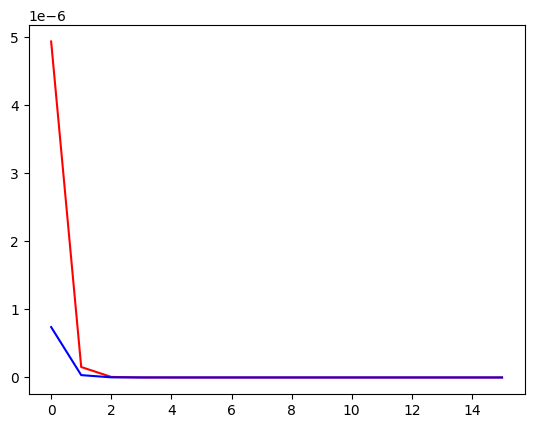

In [97]:
plt.plot(error1,'r',error2, 'b')


In [98]:
def sort_dict(ranks):
  temp=dict(ranks)
  sorted_ranks = sorted(temp.items(), key=lambda item: item[1], reverse = True)
  print("NodeId   Score")

  for i in range(10):
    print(sorted_ranks[i][0],"\t",sorted_ranks[i][1])
    i+=1

  print()
  print()
  return sorted_ranks


In [99]:
print("top 10 rank scores: ")
rank = sort_dict(rank)

print("top 10 authority scores: ")
authority = sort_dict(authority)

print("top 10 hub scores: ")
hub = sort_dict(hub)

top 10 rank scores: 
NodeId   Score
2565 	 0.0043372949187308815
11 	 0.003017206269367328
766 	 0.002968177479349323
457 	 0.002963411320667381
4037 	 0.002878218886740526
1549 	 0.0028581648714845506
1166 	 0.002669208905008099
2688 	 0.0023843472728713416
15 	 0.002163159726354969
1374 	 0.002131987766043142


top 10 authority scores: 
NodeId   Score
2565 	 0.15769611748358103
766 	 0.13015243025685455
1549 	 0.12938941353080033
1166 	 0.11950594168986171
2688 	 0.11008403659853248
457 	 0.10999186611635883
3352 	 0.09179709631226124
11 	 0.08956574261869124
1151 	 0.08717924518500951
1374 	 0.08692950770481205


top 10 hub scores: 
NodeId   Score
2565 	 0.157696117537377
766 	 0.13015243029945367
1549 	 0.12938941344572305
1166 	 0.11950594165584667
2688 	 0.11008403661789759
457 	 0.10999186615700852
3352 	 0.09179709627666102
11 	 0.08956574247014454
1151 	 0.08717924513642718
1374 	 0.08692950771109112


